# Integration with adult Pan-immune data - Lymphoid

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import sys,os
import scvi
import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import scipy

In [7]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import scvelo as scv

In [8]:
## import utils
cwd = '.'
sys.path.append(cwd)

import map_query_utils

In [9]:
## r2py setup
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

anndata2ri.activate()

In [10]:
%load_ext rpy2.ipython


In [11]:
%%R
library(tidyverse)
library(reshape2)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

In [12]:
def _plot_sorted_violin(merged_adata_bcells, groupby, y_value):
    n_cells_anno = merged_adata_bcells.obs[[groupby,y_value]].value_counts(groupby)
    keep_anno = n_cells_anno.index[n_cells_anno > 30]

    mean_sim = merged_adata_bcells.obs[[groupby,y_value]].groupby(groupby).mean()
    anno_order = mean_sim.loc[keep_anno].sort_values(y_value, ascending=False).index.tolist()

    merged_adata_bcells.var_names_make_unique()
    plt.rcParams["figure.figsize"] = [14,6]
    sc.pl.violin(merged_adata_bcells[merged_adata_bcells.obs[groupby].isin(keep_anno)], 
                                     y_value, groupby=groupby, rotation=90, 
                                     order=anno_order)

## Prepare data for mapping 

### Load full PIP dataset 

Provided by Cecilia, and re-saved by me to have EnsemblIDs as `var_names`

In [9]:
pi_adata = sc.read_h5ad('/nfs/team205/ed6/data/Fetal_immune/panimmune_query.h5ad')

### Subset to lymphoid cells

In [29]:
lymph_pi_adata = pi_adata[(~pi_adata.obs["anno_B_v2"].isna()) | (~pi_adata.obs["anno_T_2"].isna())]

In [34]:
lymph_pi_adata

View of AnnData object with n_obs × n_vars = 64978 × 33694
    obs: 'sample', 'Source ID', 'sex', 'patient no', 'organ code', 'sample ID', 'fraction_mito', 'n_genes', 'n_counts', 'log_counts', 'batch', 'empty', 'bonf_pval', 'is_doublet', 'scrublet_score', 'louvain', 'louvain_R', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'leiden', 'predicted_labels', 'over_clustering', 'majority_voting', 'leiden5', 'leiden10', 'leiden15', 'leiden20', 'cx1_anno', 'leiden_majority_anno', 'leiden1.5', 'anno', 'anno_mye', 'anno_T_2', 'anno_B_v2'
    var: 'gene_ids', 'feature_types', 'gene_names'

In [30]:
lymph_pi_adata.write_h5ad("/nfs/team205/ed6/data/Fetal_immune/panimmune_LYMPHOID_query.h5ad")
lymph_pi_adata.write_h5ad("/home/jovyan/mount/gdrive/Pan_fetal/data4gpu_node/panimmune_LYMPHOID_query.h5ad")

### Save LYMPHOID scVI model with EnsemblIDs

In [29]:
split = "LYMPHOID"
scvi_outs_dir = '/home/jovyan/mount/gdrive/Pan_fetal/data4gpu_node/'

## Read old varnames
model_dir='scvi_' + split + '_model/'
var_names_model = pd.read_csv(scvi_outs_dir + model_dir + "var_names.csv", header=None)[0].values

## Make new model folder for model with EnsemblIDs
new_model_dir = model_dir.strip("/") +"_ENSID/"
bash_call = 'cp -r {o} {n}'.format(o=scvi_outs_dir + model_dir, n=scvi_outs_dir+new_model_dir)
os.system(bash_call)

## Save var_names
adata_ref_var = pd.read_csv(scvi_outs_dir + 'PAN.A01.v01.entire_data_normalised_log.{t}.{s}.var.csv'.format(t=timestamp, s=split), index_col=0)
adata_ref_var.iloc[var_names_model]['GeneID'].to_csv(scvi_outs_dir + new_model_dir + "var_names.csv", header=None, index=False)

### Train on scVI models

On GPU node, running the call:

We merge datasets and rerun embeddings running

### Load output

In [13]:
merged_adata_file = 'panimmune_LYMPHOID_query.mapped2LYMPHOID.withReference.h5ad'
split = "LYMPHOID"
ref_data_dir = '/home/jovyan/mount/gdrive/Pan_fetal/data4gpu_node/'
data_dir ="/nfs/team205/ed6/data/Fetal_immune/"

In [10]:
merged_adata = sc.read_h5ad(ref_data_dir + merged_adata_file)

In [11]:
## Filter maternal contaminants
mat_barcodes = pd.read_csv("~/Pan_fetal_immune/metadata/souporcell_results/maternal_barcodes.csv", index_col=0)
mat_barcodes = pd.Series([x.split("-1")[0] for x in mat_barcodes['x']])
reference_obs = merged_adata.obs_names[merged_adata.obs.dataset == "reference"]
exclude_obs = reference_obs[reference_obs.str.strip("-reference").isin(mat_barcodes)]

merged_adata = merged_adata[~merged_adata.obs_names.isin(exclude_obs)].copy()

In [175]:
## Add metadata and annotations for the reference
anno_obs = pd.read_csv(data_dir + "PAN.A01.v01.entire_data_normalised_log.20210429.full_obs.annotated.clean.csv", index_col=0)

## Read annotation groupings
import json
with open('../../metadata/anno_groups.json', 'r') as json_file:
    anno_groups_dict = json.load(json_file)
    
reference_obs = merged_adata.obs_names[merged_adata.obs.dataset == "reference"]
merged_adata.obs["annotation_reference"] = np.nan
merged_adata.obs.loc[reference_obs, "annotation_reference"] = anno_obs.loc[reference_obs.str.strip("-reference")]["anno_lvl_2_final_clean"].values

merged_adata.obs["organ"] = np.nan
merged_adata.obs.loc[reference_obs, "organ"] = anno_obs.loc[reference_obs.str.strip("-reference")]["organ"].values

merged_adata.obs["age"] = np.nan
merged_adata.obs.loc[reference_obs, "age"] = anno_obs.loc[reference_obs.str.strip("-reference")]["age"].values

In [14]:
## Add metadata and annotations for the query
query_obs = merged_adata.obs_names[merged_adata.obs.dataset == "query"]
query_anno_obs = merged_adata[query_obs].obs.copy()
merged_adata.obs["annotation_query"] = np.nan
df = query_anno_obs.loc[query_obs][["anno_B_v2", "anno_T_2"]].astype("str").replace("nan", np.nan)
merged_adata.obs.loc[query_obs, "annotation_query"] = df["anno_B_v2"].combine_first(df['anno_T_2']).loc[query_obs].values

# merged_adata.obs["organ_code"] = np.nan
# merged_adata.obs.loc[query_obs, "organ_code"] = query_anno_obs.loc[query_obs.str.strip("-query")]["organ code"].values

... storing 'annotation_reference' as categorical
... storing 'annotation_query' as categorical


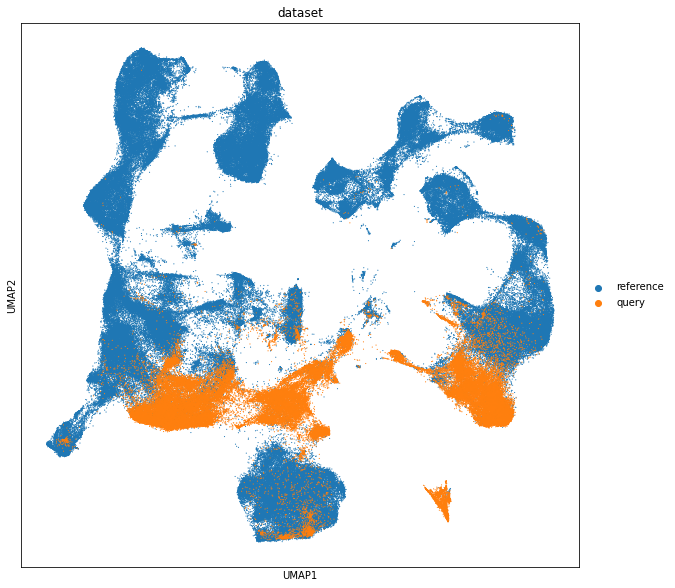

In [15]:
plt.rcParams["figure.figsize"] = [10,10]
sc.pl.umap(merged_adata, color=["dataset"], size=5)

### Plot query and reference annotations

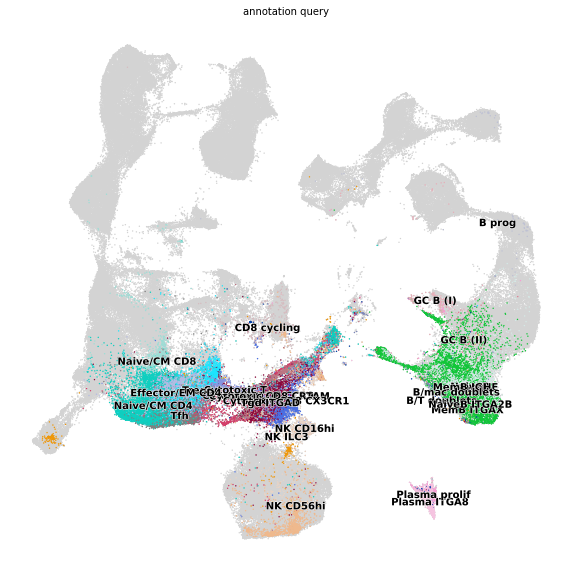

In [16]:
anno_labels = merged_adata.obs["annotation_query"][merged_adata.obs["annotation_query"]!="nan"].unique().tolist()
scv.pl.umap(merged_adata, color=["annotation_query"], size=8, legend_loc="on data", groups=anno_labels, title="annotation query")

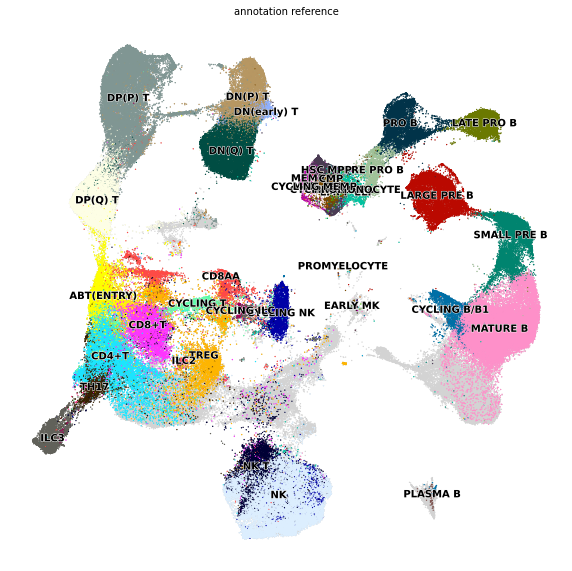

In [17]:
anno_labels = merged_adata.obs["annotation_reference"][merged_adata.obs["annotation_reference"]!="nan"].unique().tolist()
anno_labels = [x for x in anno_labels if type(x)==str]
anno_labels = [x for x in anno_labels if x not in anno_groups_dict["OTHER"]]

scv.pl.umap(merged_adata, color=["annotation_reference"], size=7, legend_loc="on data", groups=anno_labels, 
            legend_fontsize=10,
            title="annotation reference")

### Transfer labels

In [18]:
merged_adata.obs["annotation_reference"] = merged_adata.obs["annotation_reference"].astype("str").replace("nan", np.nan)
map_query_utils.predict_label(merged_adata, anno_col="annotation_reference")

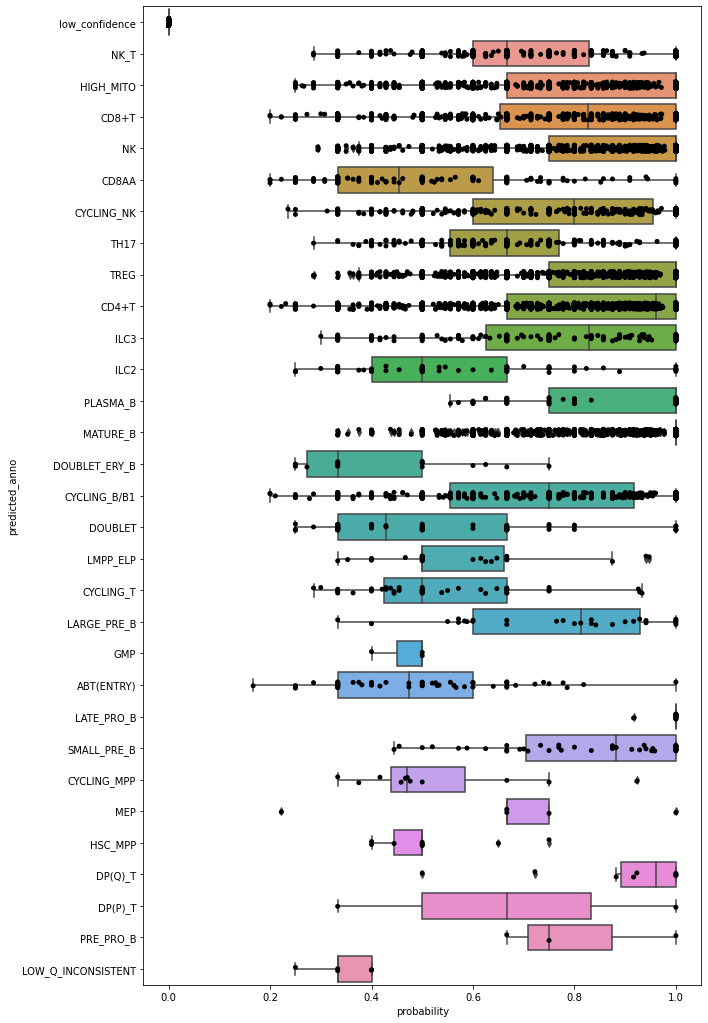

In [19]:
plt.rcParams["figure.figsize"] = [10,18]
map_query_utils.plot_predicted_anno_probability(merged_adata)

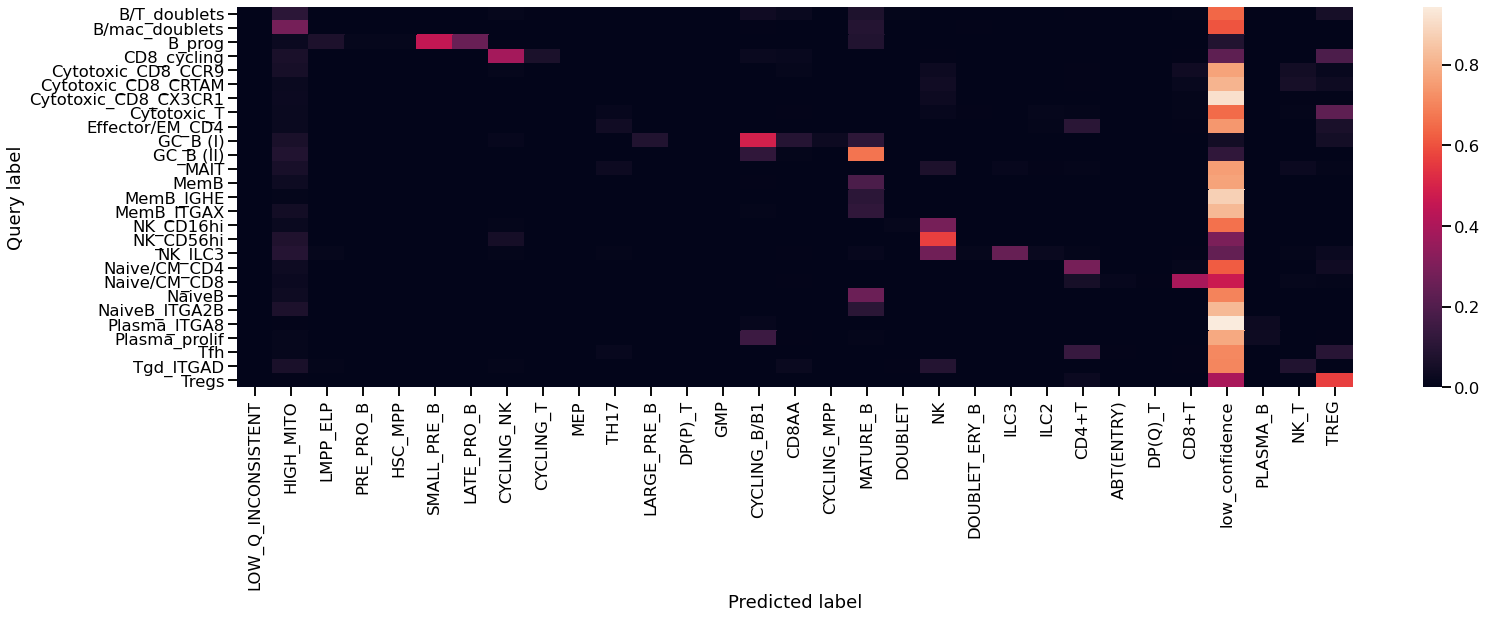

In [20]:
sns.set_context("talk")
query_anno_col="annotation_query"

query_obs = merged_adata.obs_names[merged_adata.obs.dataset == "query"]
empty_query = query_obs[merged_adata[query_obs].obs[query_anno_col]=="nan"]
merged_adata_clean = merged_adata[~merged_adata.obs_names.isin(empty_query)]

plt.rcParams["figure.figsize"] = [25,7]
map_query_utils.plot_confusion_mat(merged_adata_clean, query_anno_col=query_anno_col, show_low_confidence=True)

### Quantify matching between datasets

In [24]:
import time
start = time.time()
mnn_query, mnn_ref = map_query_utils._find_MNNs(merged_adata)
end = time.time()
print(end - start)

85.00289225578308


In [25]:
map_query_utils._MNN_to_KNN_similarity_ratio(merged_adata, mnn_ref, mnn_query)

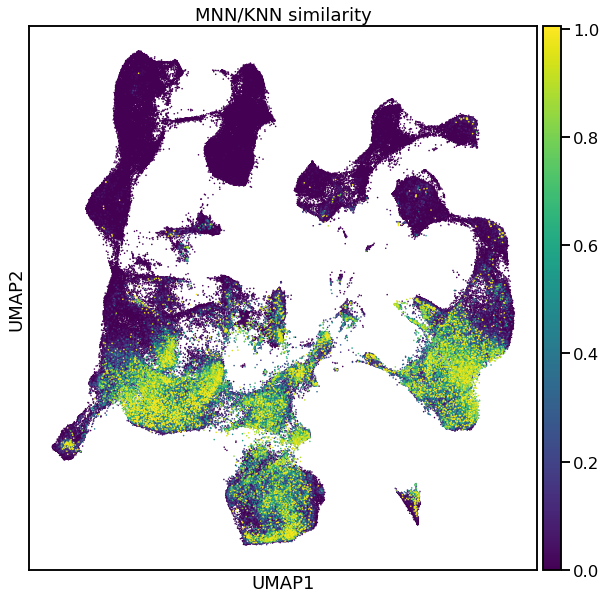

In [81]:
plt.rcParams["figure.figsize"] = [10,10]
sns.set_context("talk")
sc.pl.umap(merged_adata, color="mnn_sim_ratio", size=10, title="MNN/KNN similarity")

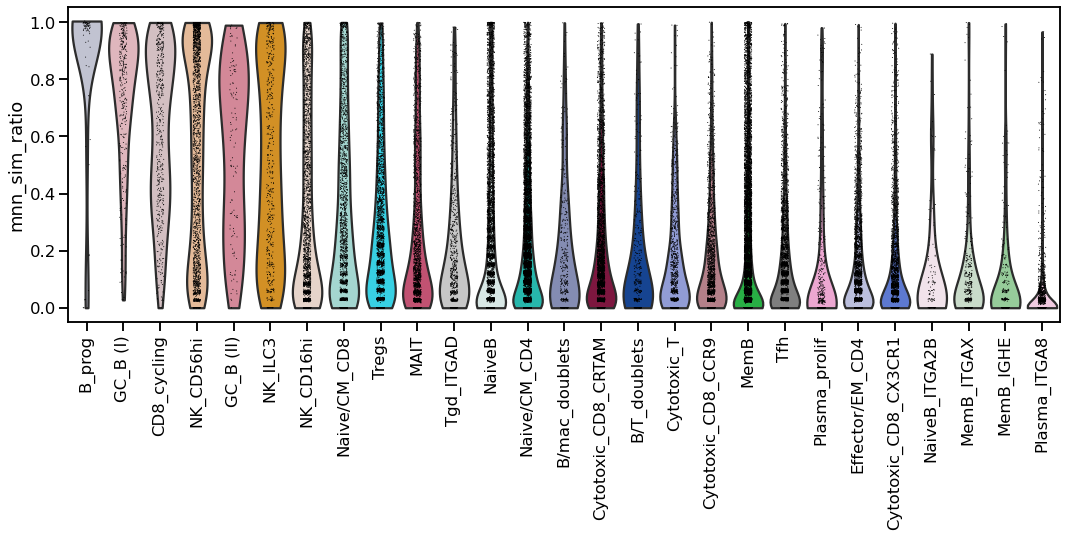

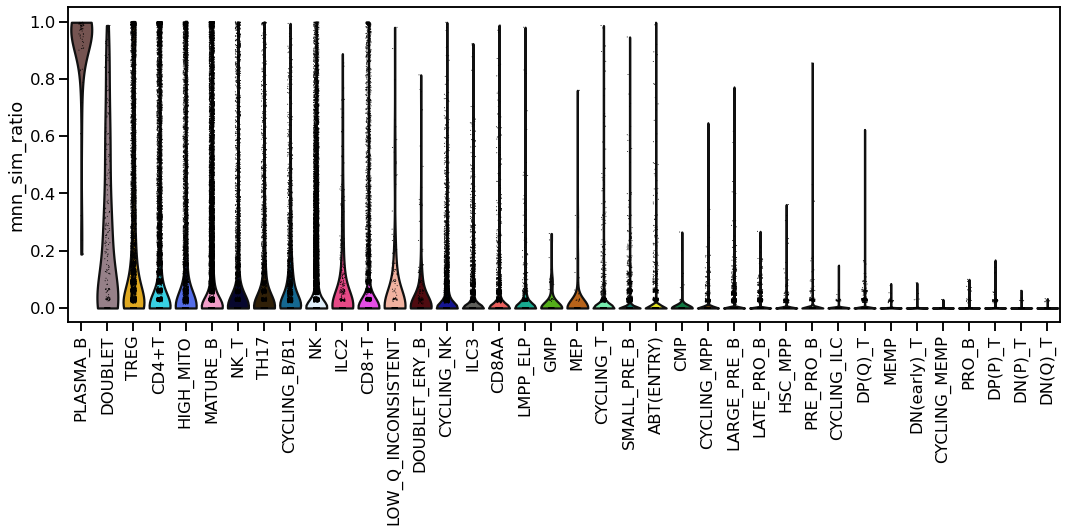

In [82]:
_plot_sorted_violin(merged_adata, "annotation_query", "mnn_sim_ratio")
_plot_sorted_violin(merged_adata, "annotation_reference", "mnn_sim_ratio")

### Save outputs

In [85]:
merged_adata.write_h5ad(data_dir + merged_adata_file)

In [14]:
merged_adata = sc.read_h5ad(data_dir + merged_adata_file)

In [30]:
data_dir + merged_adata_file

'/nfs/team205/ed6/data/Fetal_immune/panimmune_LYMPHOID_query.mapped2LYMPHOID.withReference.h5ad'

In [15]:
merged_adata

AnnData object with n_obs × n_vars = 304676 × 34241
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'name', 'sample', 'Source ID', 'sex', 'patient no', 'organ code', 'sample ID', 'fraction_mito', 'log_counts', 'batch', 'empty', 'bonf_pval', 'is_doublet', 'scrublet_score', 'louvain', 'louvain_R', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'leiden', 'predicted_labels', 'over_clustering', 'majority_voting', 'leiden5', 'leiden10', 'leiden15', 'leiden20', 'cx1_anno', 'leiden_majority_anno', 'leiden1.5', 'anno', 'anno_mye', 'anno_T_2', 'anno_B_v2', 'dataset', 'annotation_reference', 'annotation_query', 'predicted_anno', 'predicted_anno_prob', 'knn_sim', 'mnn_sim', 'mnn_sim_ratio'
    var: 'GeneID', 'GeneName', 'gene_ids', 'feature_types', 'gene_names'
    uns: '_scvi', 'annotation_query_colors', 'annotation_reference_colors', 'dataset_colors', 'neighbors', 'umap'
    obsm: 'X_scvi', 'X_umap'
    obsp: 'connectivities', 'distances'

In [21]:
merged_adata.var_names = merged_adata.var["gene_names"].values

In [27]:
sc.pp.normalize_per_cell(merged_adata, counts_per_cell_after=10e4)
sc.pp.log1p(merged_adata)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


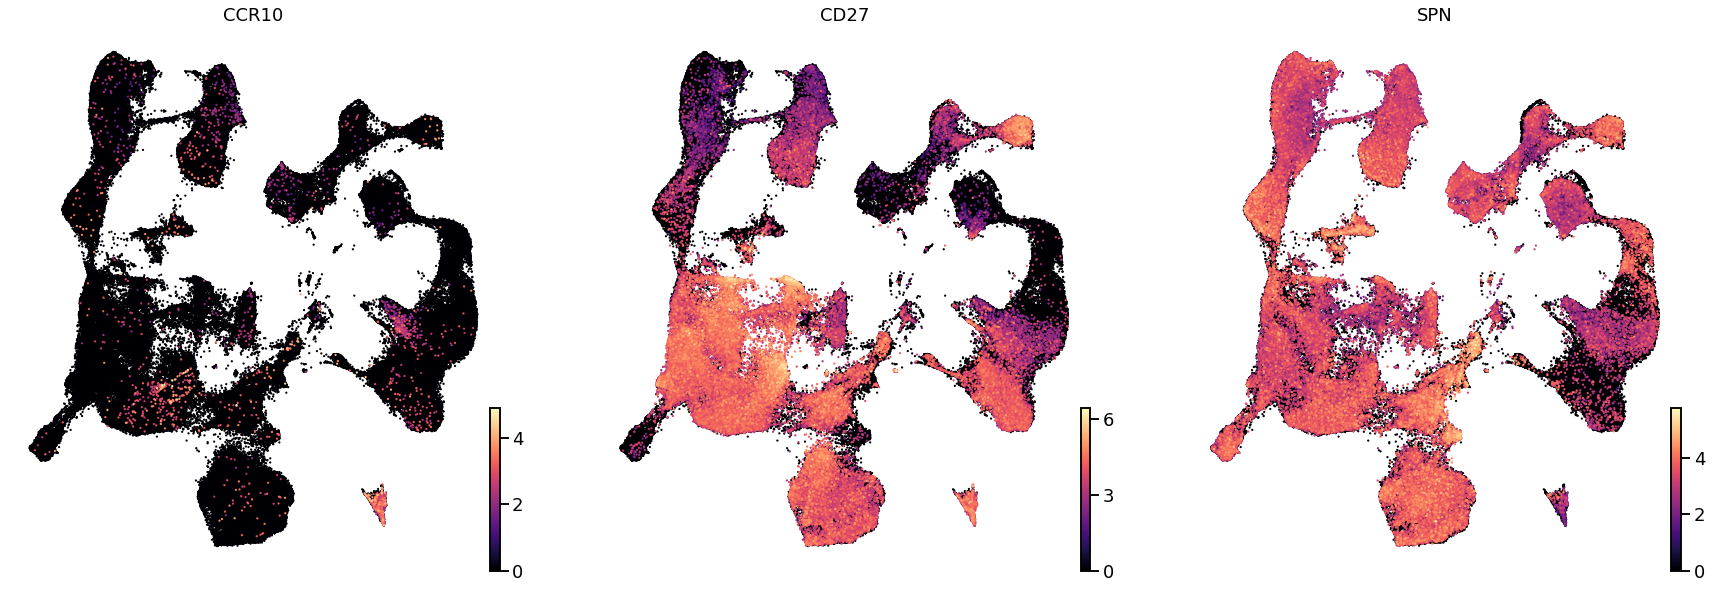

In [29]:
plt.rcParams["figure.figsize"] = [10,10]
sns.set_context("talk")
scv.pl.umap(merged_adata, color=["CCR10", "CD27","SPN"], size=20, cmap="magma")

---

### What is shared between fetal and adult?

In [156]:
merged_adata.obs["shared"] = merged_adata.obs["mnn_sim_ratio"] > 0.6

Trying to set attribute `.uns` of view, copying.


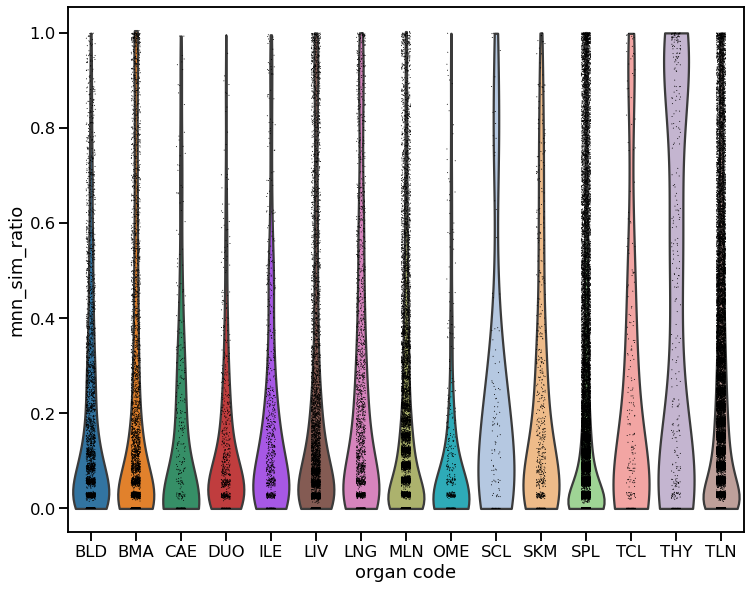

In [162]:
sc.pl.violin(merged_adata[query_obs], "mnn_sim_ratio",groupby="organ code")

In [161]:
merged_adata[query_obs].obs[["organ code", "mnn_sim_ratio"]]

organ code  mnn_sim_ratio
Pan_T7935490_AAACCTGCAAATTGCC-query        ILE       0.325178
Pan_T7935490_AAACGGGCATCTGGTA-query        ILE       0.146242
Pan_T7935490_AAACGGGTCTTGCATT-query        ILE       0.470773
Pan_T7935490_AAAGCAATCATCGCTC-query        ILE       0.000000
Pan_T7935490_AAAGTAGCAGTCACTA-query        ILE       0.372246
...                                        ...            ...
Pan_T8986831_TTCTACAAGCCTCGTG-query        LNG       0.772299
Pan_T8986831_TTGACTTGTATATGGA-query        LNG       0.891146
Pan_T8986831_TTGCCGTTCAGCAACT-query        LNG       0.319199
Pan_T8986831_TTGGAACTCTTCAACT-query        LNG       0.905818
Pan_T8986831_TTTACTGCAGATCGGA-query        LNG       0.952462

[64978 rows x 2 columns]

## Putative B1 cells

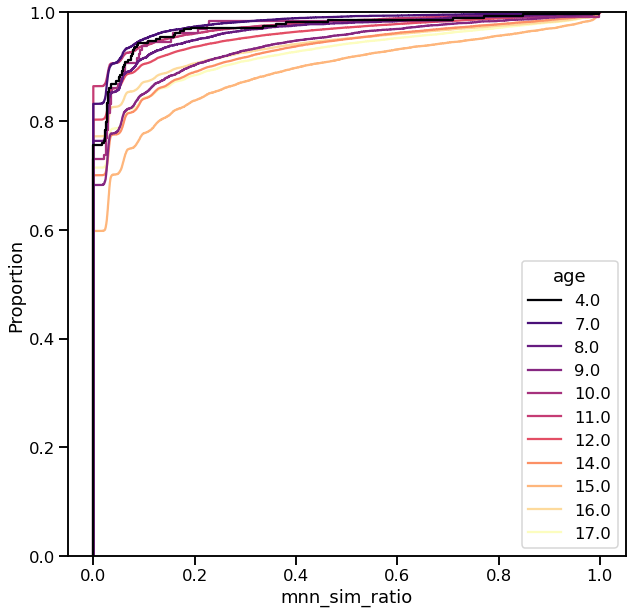

In [180]:
sns.ecdfplot(data=merged_adata.obs[["mnn_sim_ratio", "age"]], x="mnn_sim_ratio", hue="age", palette='magma');

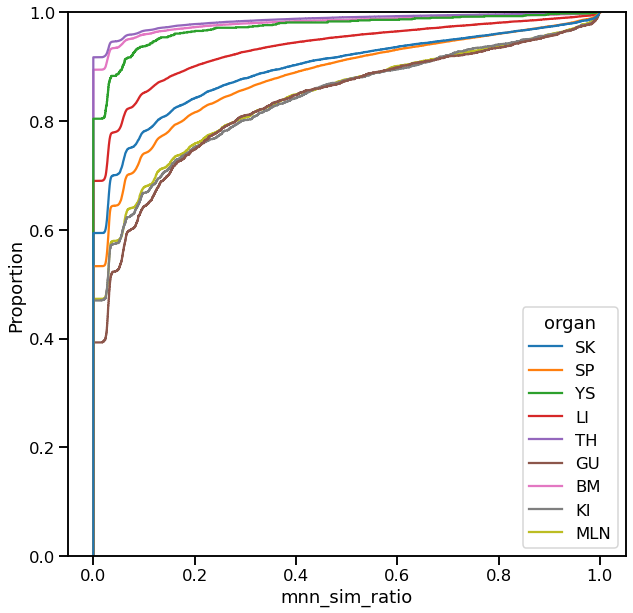

In [176]:
sns.ecdfplot(data=merged_adata.obs[["mnn_sim_ratio", "organ"]], x="mnn_sim_ratio", hue="organ");

Trying to set attribute `.obs` of view, copying.
... storing 'annotation_reference' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'organ' as categorical


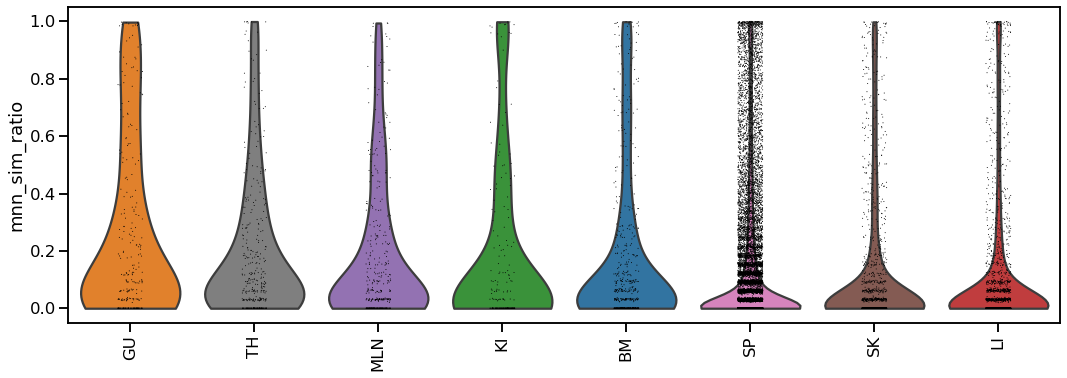

Trying to set attribute `.obs` of view, copying.
... storing 'annotation_reference' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'organ' as categorical


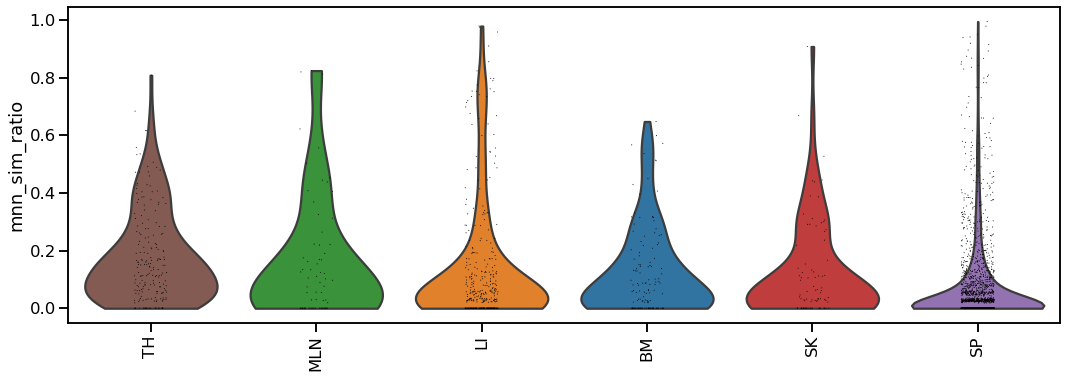

In [185]:
_plot_sorted_violin(merged_adata[merged_adata.obs["annotation_reference"] == "MATURE_B"], "organ", "mnn_sim_ratio")
_plot_sorted_violin(merged_adata[merged_adata.obs["annotation_reference"] == "CYCLING_B/B1"], "organ", "mnn_sim_ratio")

In [3]:
df = merged_adata.obs[["annotation_reference", "organ", "age", "mnn_sim_ratio", "annotation_query", "organ code"]]

NameError: name 'merged_adata' is not defined

In [201]:
%%R -i df
head(df)

                                          annotation_reference organ age
FCAImmP7579224-CTAATGGCACTGTGTA-reference          LARGE_PRE_B    SK  12
FCAImmP7579224-ATTATCCAGAGAACAG-reference   LOW_Q_INCONSISTENT    SK  12
FCAImmP7579224-GACGGCTAGCCACCTG-reference            CYCLING_T    SK  12
FCAImmP7579224-GCGGGTTGTCCGAGTC-reference            CYCLING_T    SK  12
FCAImmP7579224-AGTTGGTAGTGTTAGA-reference            CYCLING_T    SK  12
FCAImmP7579224-TCTTTCCCAAGCCGTC-reference            PRE_PRO_B    SK  12
                                          mnn_sim_ratio annotation_query
FCAImmP7579224-CTAATGGCACTGTGTA-reference             0             <NA>
FCAImmP7579224-ATTATCCAGAGAACAG-reference             0             <NA>
FCAImmP7579224-GACGGCTAGCCACCTG-reference             0             <NA>
FCAImmP7579224-GCGGGTTGTCCGAGTC-reference             0             <NA>
FCAImmP7579224-AGTTGGTAGTGTTAGA-reference             0             <NA>
FCAImmP7579224-TCTTTCCCAAGCCGTC-reference          

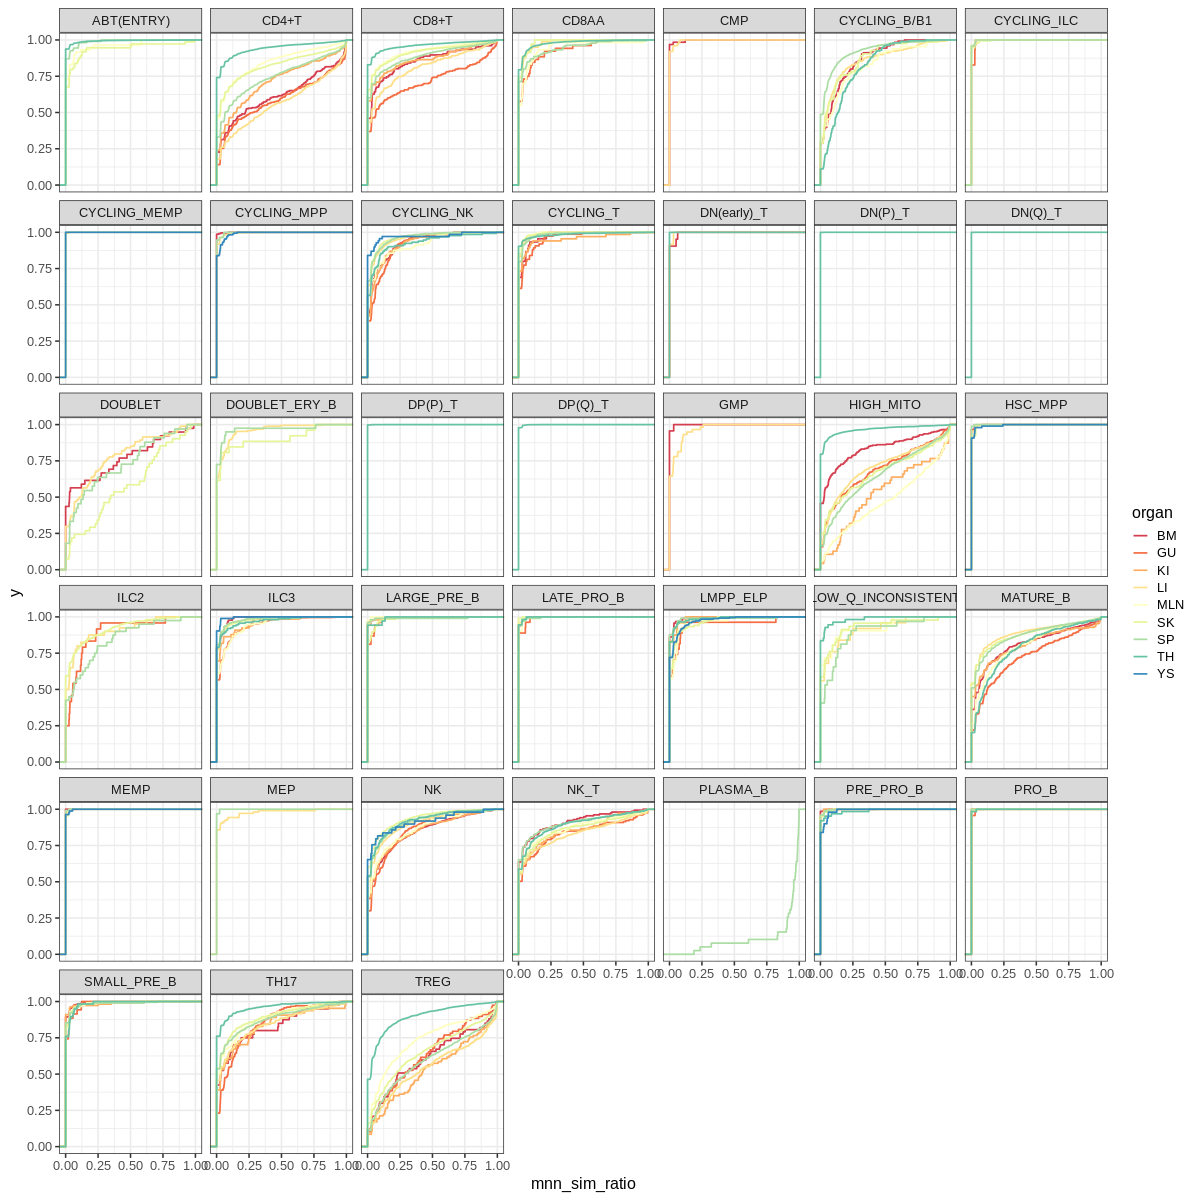

In [199]:
%%R -w 1200 -h 1200
df %>%
    filter(!is.na(organ)) %>%
    group_by(annotation_reference, organ) %>%
    filter(n() > 20) %>%
    ggplot(aes(mnn_sim_ratio, color=organ)) +
    stat_ecdf(size=0.8) +
    theme_bw(base_size=16) +
    facet_wrap(annotation_reference~.) +
    scale_color_brewer(palette = "Spectral")

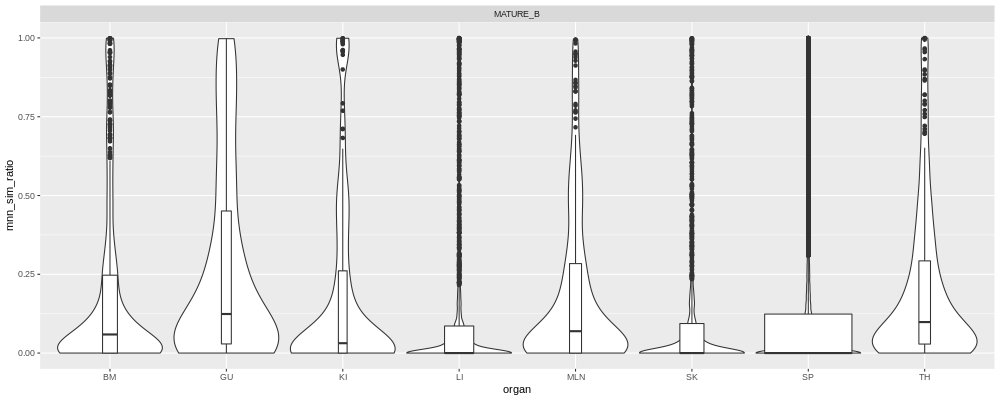

In [224]:
%%R -w 1000 -h 400
df %>%
    group_by(annotation_reference, organ) %>%
    filter(n() > 20) %>%
    filter(annotation_reference %in% c("MATURE_B")) %>%
    ggplot(aes(organ, mnn_sim_ratio)) +
    geom_violin(scale="width") +
    geom_boxplot(varwidth=TRUE) +
    facet_wrap(annotation_reference~.)

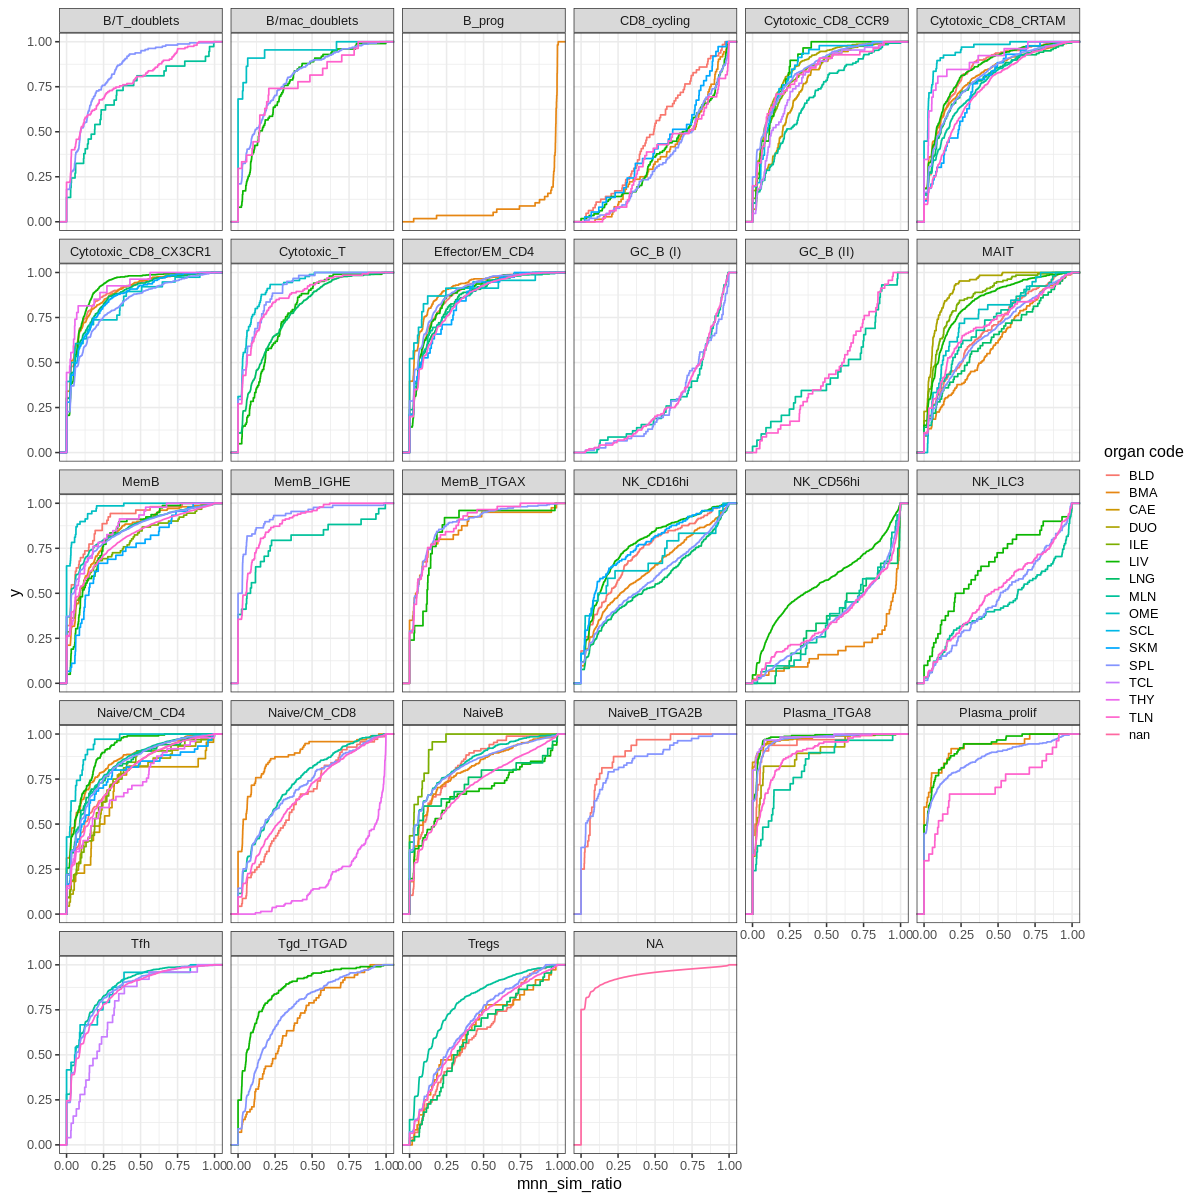

In [208]:
%%R -w 1200 -h 1200
df %>%
    filter(!is.na(`organ code`)) %>%
    group_by(annotation_query, `organ code`) %>%
    filter(n() > 20) %>%
    ggplot(aes(mnn_sim_ratio, color=`organ code`)) +
    stat_ecdf(size=0.8) +
    theme_bw(base_size=16) +
    facet_wrap(annotation_query~.) 


Interesting:
- MAIT cells
- NK CD56hi
- Naive CD8

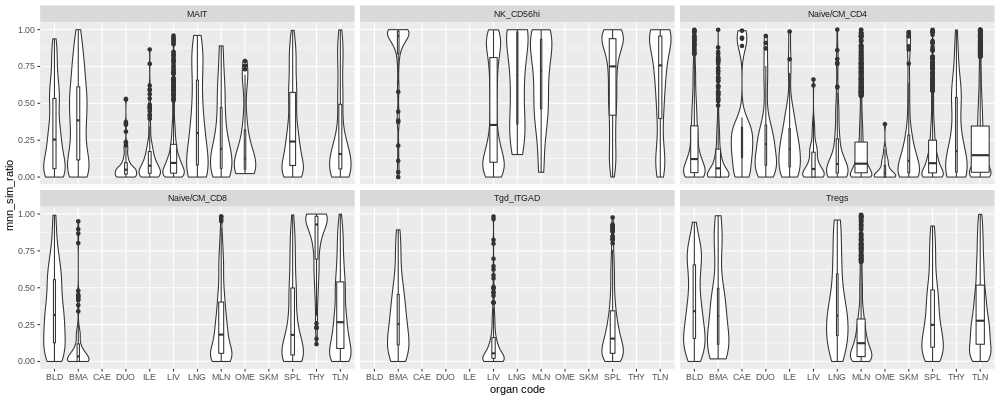

In [221]:
%%R -w 1000 -h 400
df %>%
    group_by(annotation_query, `organ code`) %>%
    filter(n() > 20) %>%
    filter(annotation_query %in% c("Naive/CM_CD8", "Naive/CM_CD4", "NK_CD56hi", "MAIT", "Tgd_ITGAD", "Tregs")) %>%
ggplot(aes(`organ code`, mnn_sim_ratio)) +
geom_violin(scale="width") +
geom_boxplot(varwidth=TRUE) +
facet_wrap(annotation_query~.)

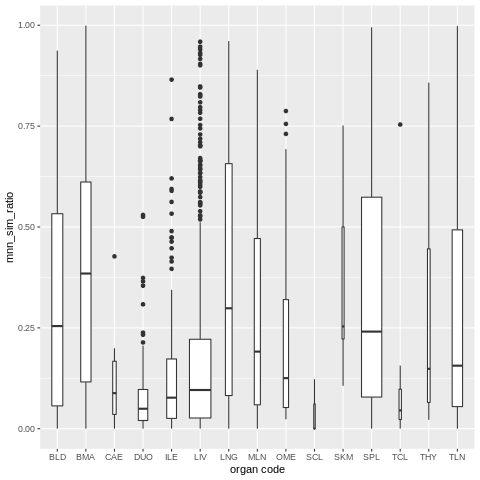

In [210]:
%%R
df %>%
filter(annotation_query=="MAIT") %>%
ggplot(aes(`organ code`, mnn_sim_ratio)) +
geom_boxplot(varwidth=TRUE)

Let's try reclustering B cells based on the embedding with adult cells and see if we get a separation of the Cyclying_B/B1 cluster  

In [89]:
sc.tl.leiden(merged_adata, resolution=2)

In [98]:
merged_adata.var_names = merged_adata.var["GeneName"].values

In [101]:
sc.pp.normalize_per_cell(merged_adata, counts_per_cell_after=10e4)
sc.pp.log1p(merged_adata)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


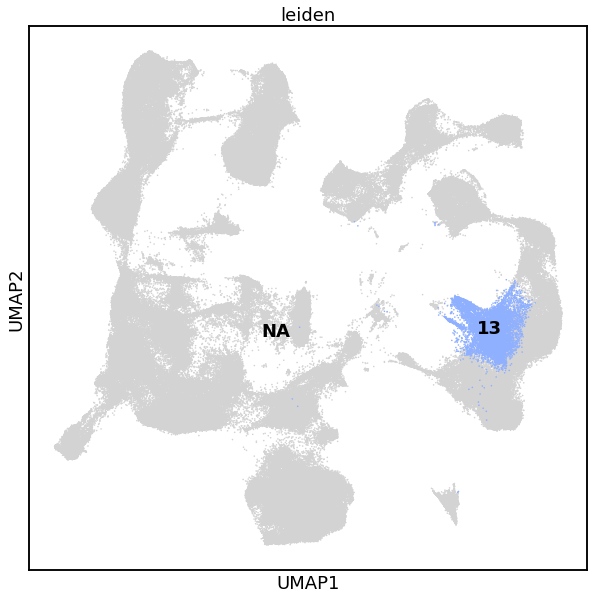

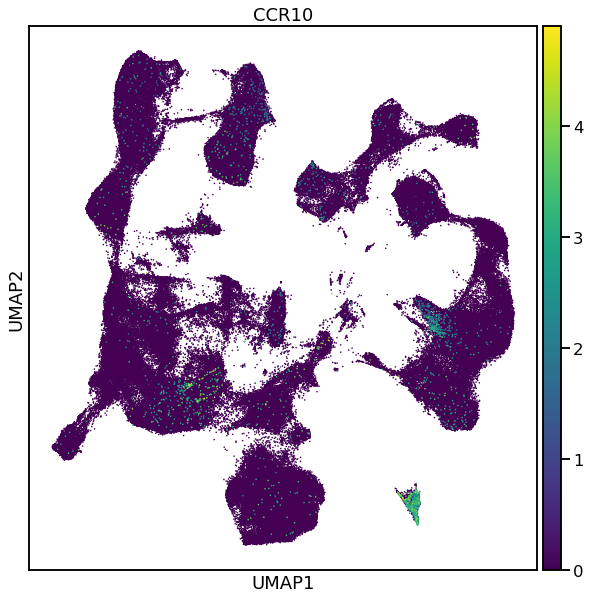

In [102]:
plt.rcParams["figure.figsize"] = [10,10]
sc.pl.umap(merged_adata, color='leiden', legend_loc="on data", groups=["13"], size=10)
sc.pl.umap(merged_adata, color='CCR10', size=10)

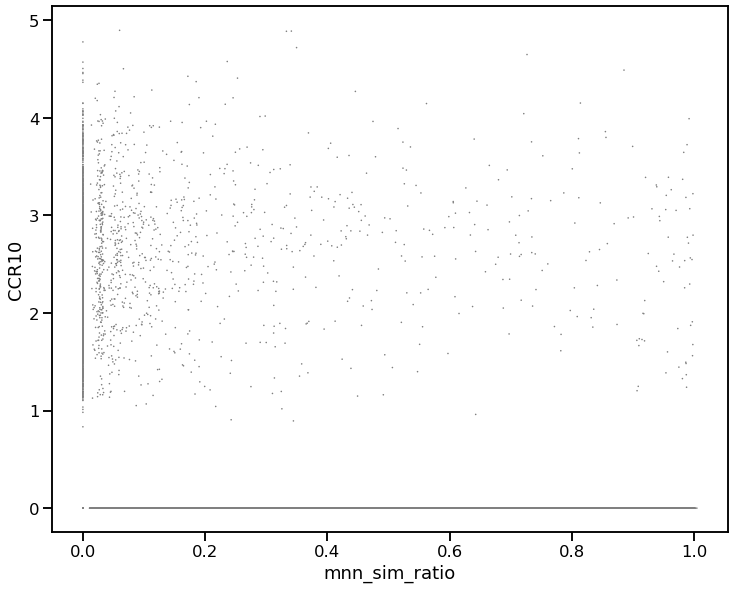

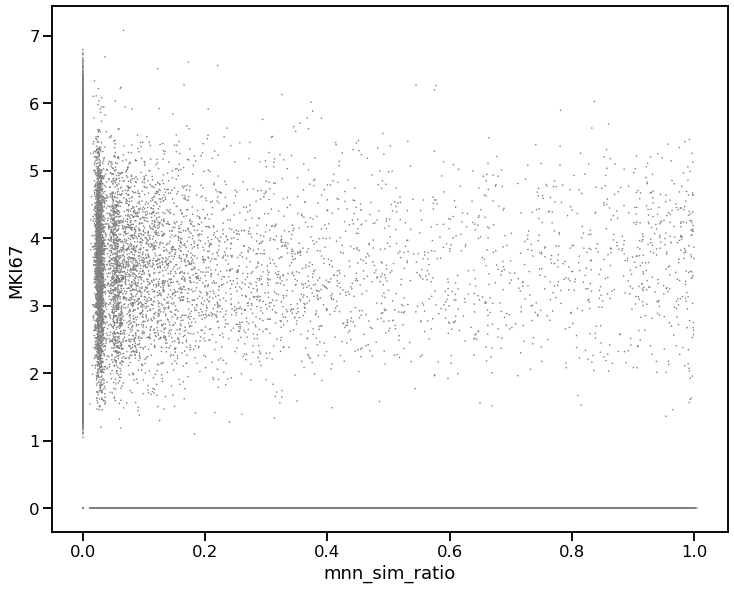

In [105]:
sc.pl.scatter(merged_adata, "mnn_sim_ratio","CCR10", size=10)
sc.pl.scatter(merged_adata, "mnn_sim_ratio","MKI67", size=10)

In [125]:
cut_bins = np.linspace(0,1,10)
merged_adata.obs["sim_ratio_bins"] = pd.cut(merged_adata.obs["mnn_sim_ratio"], bins=cut_bins, include_lowest=True)
merged_adata.obs["sim_ratio_bins"] = pd.Categorical(merged_adata.obs["sim_ratio_bins"], ordered=True)


In [115]:
merged_adata.var_names_make_unique()

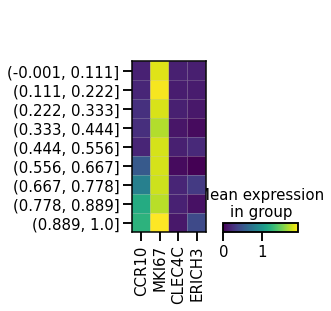

In [135]:
sc.pl.matrixplot(merged_adata[merged_adata.obs["annotation_reference"] == "CYCLING_B/B1"], ["CCR10", "MKI67", "CLEC4C","ERICH3"], groupby='sim_ratio_bins')

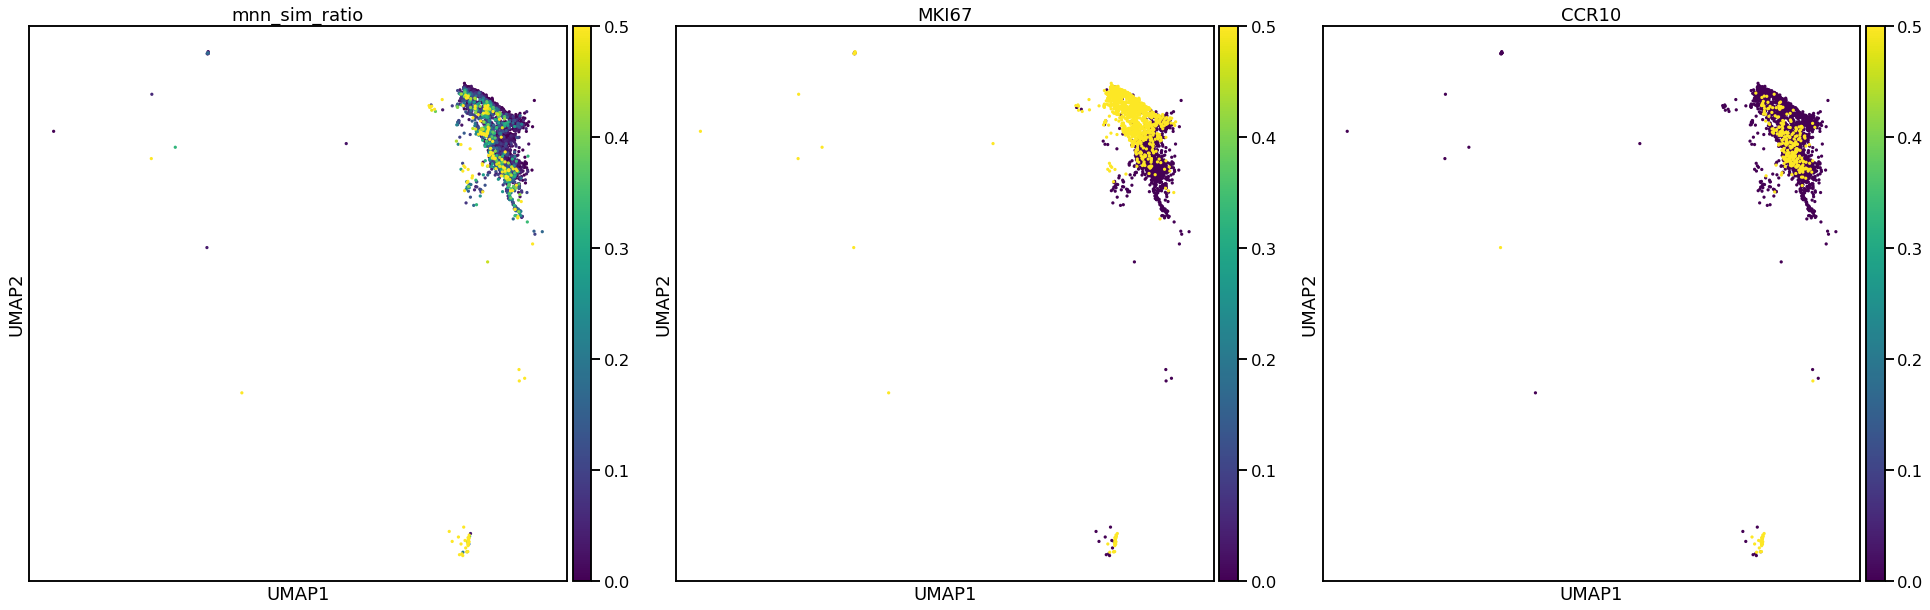

In [143]:
sc.pl.umap(merged_adata[merged_adata.obs["annotation_reference"] == "CYCLING_B/B1"], color=["mnn_sim_ratio","MKI67", "CCR10"], vmax=0.5)

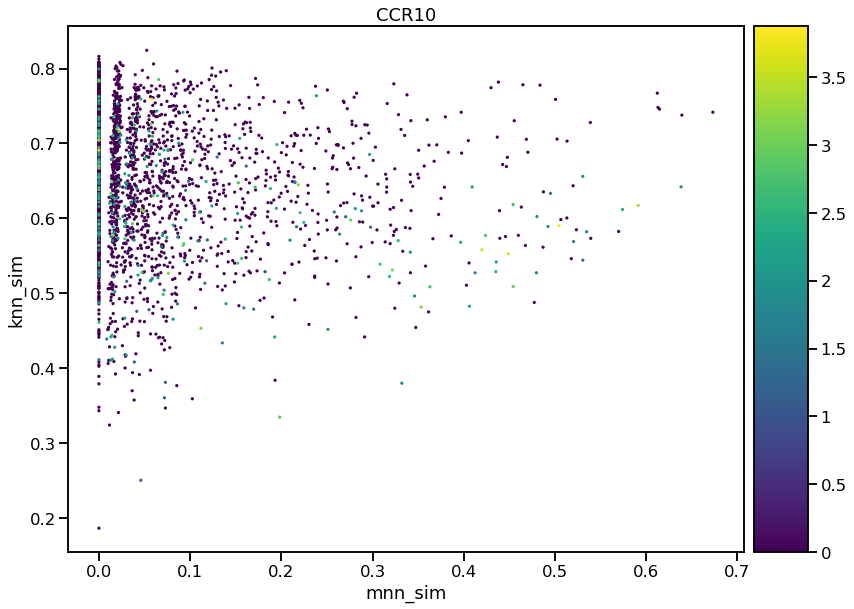

In [153]:
sc.pl.scatter(merged_adata[merged_adata.obs["annotation_reference"] == "CYCLING_B/B1"], "mnn_sim", "knn_sim", color=["CCR10", ""])

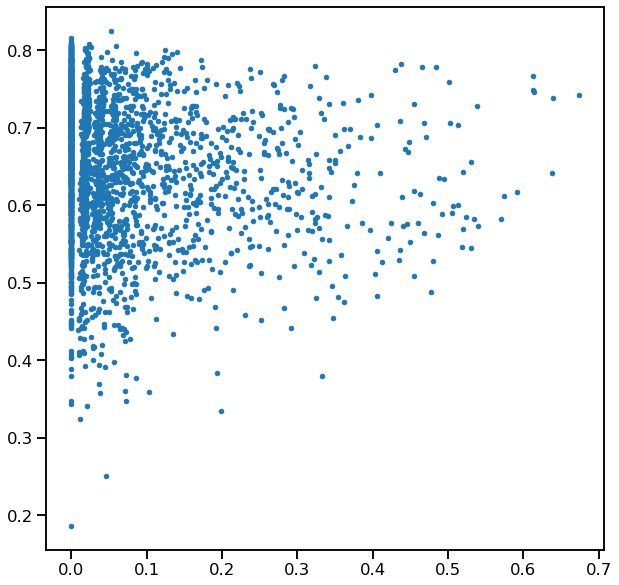

In [148]:
plt.plot(merged_adata[merged_adata.obs["annotation_reference"] == "CYCLING_B/B1"].obs["mnn_sim"],
        merged_adata[merged_adata.obs["annotation_reference"] == "CYCLING_B/B1"].obs["knn_sim"], '.')

---

## Junk n snippets